# Imports

In [66]:
import os 
import warnings

warnings.filterwarnings("ignore")
os.chdir("/Users/erjo3868/repos/hypedsearch/hypedsearch")
print(f"cwd = {os.getcwd()}")

from src.erik import load_comet_data
import numpy as np
from src.erik import (
    get_data_for_spectrum, 
    get_b_y_ion_sequences, 
    get_b_ion_sequences, 
    get_y_ion_sequences, 
    load_mzml_data,
    get_specific_spectrum,
    mass_difference_in_ppm,
    get_ion_matches_between_peptide_and_spectrum_peaks,
    compare_comet_output_row_to_corresponding_spectrum
)
from src.lookups.protein_product_ion_db import (
    compute_b_ion_neutral_mass,
    compute_y_ion_neutral_mass
)
from src.erik_utils import run_in_parallel, timeit
from src.erik_constants import SAMPLE, SCAN
from typing import Counter
from src.ryans_get_mass_code import calc_masses, b_ions
import seaborn as sns
from src.plot_utils import fig_setup, finalize, set_title_axes_labels
import pandas as pd

PMZ = "precursor_mz"
PC = "precursor_charge"
C = "charge"
ENM = "exp_neutral_mass"
XC = "xcorr"
PP = "plain_peptide"
PL = "peptide_len"
IM = "ions_matched"


cwd = /Users/erjo3868/repos/hypedsearch/hypedsearch


# Load Comet and spectra (MZML) data

In [3]:
# Load comet data
comet_df = load_comet_data()
comet_df.head(2)


Reading data for BMEM_AspN_Fxn4
Reading data for BMEM_AspN_Fxn5
Reading data for BMEM_AspN_Fxn6
Reading data for BMEM_AspN_Fxn7
Reading data for BMEM_AspN_Fxn8
Reading data for BMEM_AspN_Fxn9


,scan,num,charge,exp_neutral_mass,calc_neutral_mass,e-value,xcorr,delta_cn,sp_score,ions_matched,...,plain_peptide,modified_peptide,prev_aa,next_aa,protein,protein_count,modifications,retention_time_sec,sp_rank,sample
0,7,1,3,1525.774133,1525.773636,0.000202,2.187,0.4294,229.0,15,...,SAAPAAGSAPAAAEEKK,G.SAAPAAGSAPAAAEEKK.D,G,D,"tr|A0A5F8MPY2|A0A5F8MPY2_MOUSE,sp|P99027|RLA2_...",2,-,714.0,1,BMEM_AspN_Fxn4
1,7,2,3,1525.774133,1525.773636,2.030000,1.248,0.0200,26.0,6,...,AAQTPGSGEAVLSKNP,T.AAQTPGSGEAVLSKNP.N,T,N,sp|Q8BI84|TGO1_MOUSE,1,-,714.0,16,BMEM_AspN_Fxn4


In [ ]:
mzml_df = load_mzml_data()


# EDA

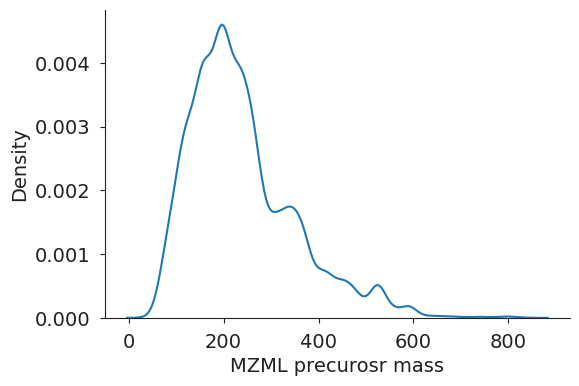

In [9]:
_, axs = fig_setup(1,1)
_=sns.kdeplot(data=(mzml_df[PMZ] / mzml_df[PC]) , ax=axs[0])
set_title_axes_labels(axs[0], xlabel="MZML precurosr mass", ylabel="Density")
finalize(axs)


# `exp_neutral_mass`

In [7]:
PMZ = "precursor_mz"
PC = "precursor_charge"
C = "charge"
ENM = "exp_neutral_mass"

# See if exp_neutral_mass makes sense
result = []
for group_name, group_df in comet_df.groupby(["sample", "scan"]):
    sample, scan_num = group_name[0], int(group_name[1])
    comet_exp_neut_mass = np.unique(group_df[ENM])
    assert (len(comet_exp_neut_mass) == 1)
    comet_exp_neut_mass = comet_exp_neut_mass[0]

    # Get precursor mass from MZML
    spectrum = mzml_df[(mzml_df[SCAN]==scan_num) & (mzml_df["mzml"] == f"{sample}.mzML")]
    assert spectrum.shape[0] == 1, "Should only be one matching spectrum"
    spectrum = spectrum.iloc[0]
    mzml_mass = spectrum[PC] * spectrum[PMZ]

    result.append(abs(mzml_mass - comet_exp_neut_mass))

    # For testing
    # sample, scan_num
    # break

In [8]:
Counter(result)

Counter({np.float64(2.014552999999978): 8181,
         np.float64(3.021829000000025): 2226,
         np.float64(2.0145530000000917): 821,
         np.float64(3.021828999999798): 533,
         np.float64(2.0145530000002054): 495,
         np.float64(3.0218290000002526): 209,
         np.float64(3.0218289999999115): 80,
         np.float64(3.021829000000139): 18,
         np.float64(2.0145529999998644): 3})

# `ions_matched`

In [68]:
# Sort so best spectrum-peptide matches are first
import time


df = comet_df.sort_values(by="xcorr", ascending=False)
df.reset_index(inplace=True, drop=True)

# Add a peptide length column
df[PL] = df[PP].apply(lambda peptide: len(peptide))

ppm_tol = 10
charges_to_consider = [1, 2, 3]
results = []
# rows = [row for _, row in df.iterrows()]

results = []
t0 = time.time()
for row_idx, row in df.iterrows():
    if row_idx % 100 == 0:
        print(f"Row = {row_idx+1} of {df.shape[0]}")
    results.append(
        compare_comet_output_row_to_corresponding_spectrum(
            row=df.iloc[0],
            charges_to_consider=charges_to_consider,
            ppm_tolerance=ppm_tol
        )
    )
print(f"Took {time.time()-t0:.3f} seconds")

# # )

Row = 1 of 62323
Row = 101 of 62323
Row = 201 of 62323
Row = 301 of 62323
Row = 401 of 62323
Row = 501 of 62323
Row = 601 of 62323
Row = 701 of 62323
Row = 801 of 62323
Row = 901 of 62323
Row = 1001 of 62323
Row = 1101 of 62323
Row = 1201 of 62323
Row = 1301 of 62323
Row = 1401 of 62323
Row = 1501 of 62323
Row = 1601 of 62323
Row = 1701 of 62323
Row = 1801 of 62323
Row = 1901 of 62323
Row = 2001 of 62323
Row = 2101 of 62323
Row = 2201 of 62323
Row = 2301 of 62323
Row = 2401 of 62323
Row = 2501 of 62323
Row = 2601 of 62323
Row = 2701 of 62323
Row = 2801 of 62323
Row = 2901 of 62323
Row = 3001 of 62323
Row = 3101 of 62323
Row = 3201 of 62323
Row = 3301 of 62323
Row = 3401 of 62323
Row = 3501 of 62323
Row = 3601 of 62323
Row = 3701 of 62323
Row = 3801 of 62323
Row = 3901 of 62323
Row = 4001 of 62323
Row = 4101 of 62323
Row = 4201 of 62323
Row = 4301 of 62323
Row = 4401 of 62323
Row = 4501 of 62323
Row = 4601 of 62323
Row = 4701 of 62323
Row = 4801 of 62323
Row = 4901 of 62323
Row = 5001 o

KeyboardInterrupt: 

In [87]:
seq = comet_df["plain_peptide"][0]
seq
b_ions(sequence=seq, charge=1)
# This is weird. You'd expect this function to give you the masses for all the b-ions in the sequence

'SAAPAAGSAPAAAEEKK'

[1508.770348435]